In [127]:
!pip install pyspark
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install wordcloud
!pip install nltk

In [128]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("NLTP").getOrCreate()
dados = spark.read.csv("imdb-reviews-pt-br.csv", inferSchema=True, escape= '\"', header=True)

In [129]:
dados.show(10)

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
+---+--------------------+--------------------+---------+
only showing top 10 rows



In [130]:
positivo = dados.filter(dados['id'] == 12427)
positivo.select('text_pt').show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                                                                                                                                                                                        

In [131]:
negativo = dados.filter(dados['id'] == 190)
negativo.select('text_pt').show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                                          

In [132]:
dados.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      neg|24765|
|      pos|24694|
+---------+-----+



In [133]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

amostra = dados.select('text_pt').sample(fraction = 0.1, seed = 101)

In [134]:
todas_as_palavras = [texto['text_pt'] for texto in amostra.collect()]
todas_as_palavras


['"Tokyo Eyes" fala de uma menina japonesa de 17 anos que cai como um homem sendo caçado por seu irmão mais velho que é um policial. Este filme manco é de cerca de 50% de enchimento e 50% de conversas, conversas e mais conversas. Você verá o elenco estelar de menos de três pessoas enquanto eles conversam no ônibus, conversam e jogam videogames, conversam e cortam o cabelo, conversam e andam e andam e conversam, conversam no celular, passam o tempo conversando etc. enquanto você lê legendas esperando que algo aconteça. O fino fio de uma história não é suficiente para sustentar um filme com baixo valor de produção final, um elenco escasso, e sem ação, sem romance, sem sexo ou nudez, sem drama pesado ... apenas incessante yadayadayadaing. C-',
 'Cage interpreta um bêbado e é elogiado pela crítica. Elizabeth Shue Na verdade, tem que fazer um amor com a parte mais desprezível e superestimada de estrume em Hollywood. Eu literalmente vomitei enquanto assistia a esse filme. Claro que tive grip

In [135]:
wordcloud = WordCloud(background_color = 'white',
                      width = 1000,
                      height = 600,
                      collocations = False,
                      prefer_horizontal = 1).generate(str(todas_as_palavras))

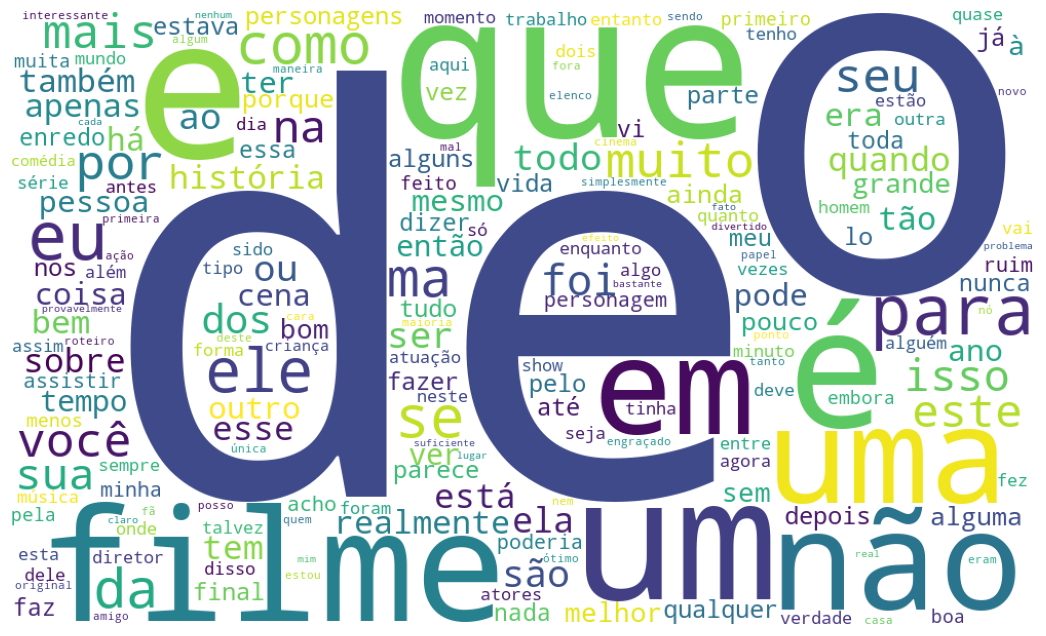

In [136]:
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [137]:
import string
string.punctuation


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [138]:
import pyspark.sql.functions as f
amostra = spark.createDataFrame([
    ("Oi, JP! Blz?",),
    ("$$$\\ |~ Parabéns ~| \\$$$",),
    ("(#amovc #paz&amor ^.^)",),
    ("\"bora *_* \"",),
    ("=>->'...``` vc foi selecionad@ ´´´...'<=<-",),
    ("{comprar: arroz; feijão e pepino} //",),
    ("!\"#$&'()*+,-./:;<=>?@[\]^_`{|}~",),
    ("ana@gmail.com",)
], ["textos"])

In [139]:
amostra = amostra.withColumn("texto_regex", f.regexp_replace("textos", "\$", ""))

In [140]:
amostra = amostra.withColumn("texto_regex", f.regexp_replace("textos", "[\$#,\"!%&'()*+-./;;<=>?@^_`´{|}~\\\\]", ""))
amostra.show(truncate = False)

+------------------------------------------+-------------------------------+
|textos                                    |texto_regex                    |
+------------------------------------------+-------------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                      |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                     |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                  |
|"bora *_* "                               |bora                           |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad             |
|{comprar: arroz; feijão e pepino} //      |comprar: arroz feijão e pepino |
|!"#$&'()*+,-./:;<=>?@[\]^_`{|}~           |:[]                            |
|ana@gmail.com                             |anagmailcom                    |
+------------------------------------------+-------------------------------+



In [141]:
amostra = amostra.withColumn("texto_limpo", f.trim(amostra.texto_regex))
amostra.show(truncate = False)

+------------------------------------------+-------------------------------+------------------------------+
|textos                                    |texto_regex                    |texto_limpo                   |
+------------------------------------------+-------------------------------+------------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                      |Oi JP Blz                     |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                     |Parabéns                      |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                  |amovc pazamor                 |
|"bora *_* "                               |bora                           |bora                          |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad             |vc foi selecionad             |
|{comprar: arroz; feijão e pepino} //      |comprar: arroz feijão e pepino |comprar: arroz feijão e pepino|
|!"#$&'()*+,-./:;<=>?@[\]^_`

In [262]:
dados = dados.withColumn("texto_regex", f.regexp_replace("text_en", "[\$#,\"!%&'()*+-./;;<=>?@^_`´{|}~\\\\]", ""))
dados = dados.withColumn("texto_limpo", f.regexp_replace("text_en", "[\$#,\"!%&'()*+-./;;<=>?@^_`´{|}~\\\\]", ""))



In [264]:
dados = dados.withColumn("texto_regex", f.trim(dados.texto_regex))
dados = dados.withColumn("texto_limpo", f.trim(dados.texto_regex))


In [265]:
dados.limit(2).show(truncate = False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [232]:
from pyspark.ml.feature import Tokenizer
tokenizer = Tokenizer(inputCol = "texto_regex", outputCol = "tokens")
tokenizado = tokenizer.transform(dados)

In [233]:
tokenizado.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|              tokens|
+---+--------------------+--------------------+---------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|[once, again, mr,...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|[this, is, an, ex...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|[first, of, all, ...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|[not, even, the, ...|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|[brass, pictures,...|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|A funny thing hap...|[a, funny, thing,...|
|  7|This German horro...|Este filme de ter...|      neg|This German horro...|[this, german, ho...|


In [234]:
from pyspark.sql.types import IntegerType
def calculaTokens(tokens):
    return len(tokens)
udf_calcula_tokens = f.udf(calculaTokens, IntegerType())


In [148]:
tokenizado.select("texto_regex", "tokens")\
    .withColumn('freq_tokens', udf_calcula_tokens(f.col('tokens')))\
    .show()

+--------------------+--------------------+-----------+
|         texto_regex|              tokens|freq_tokens|
+--------------------+--------------------+-----------+
|Once again Mr Cos...|[once, again, mr,...|        168|
|This is an exampl...|[this, is, an, ex...|        232|
|First of all I ha...|[first, of, all, ...|        215|
|Not even the Beat...|[not, even, the, ...|        308|
|Brass pictures mo...|[brass, pictures,...|        238|
|A funny thing hap...|[a, funny, thing,...|        115|
|This German horro...|[this, german, ho...|        156|
|Being a longtime ...|[being, a, longti...|        136|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|        129|
|Wealthy horse ran...|[wealthy, horse, ...|        160|
|Cage plays a drun...|[cage, plays, a, ...|        109|
|First of all I wo...|[first, of, all, ...|        333|
|So tell me  what ...|[so, tell, me, , ...|        243|
|A big disappointm...|[a, big, disappoi...|        110|
|This film is abso...|[this, film, is, ...|     

In [238]:
tokenizado =  tokenizado.select("*") \
    .withColumn('freq_tokens', udf_calcula_tokens(f.col('tokens')))

In [236]:
tokenizado.select("freq_tokens").groupby().mean().show()

+------------------+
|  avg(freq_tokens)|
+------------------+
|218.68559817222345|
+------------------+



In [151]:
data = [(1, 'Spark é ótimo e NLP com Spark é fácil'),
        (0, 'Spark MLlib não ajuda muito'),
        (1, 'O MLlib do Spark ajuda e é fácil')]

colNames =['label', 'texto_limpo']
df = spark.createDataFrame(data, colNames)

In [152]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol= "tokens")
tokenized = tokenizer.transform(df)

In [153]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leonardogloria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [154]:
from nltk.corpus import stopwords
stop_A_portuguese = stopwords.words("portuguese")

In [155]:
from pyspark.ml.feature import StopWordsRemover

stop_B_portuguese = StopWordsRemover.loadDefaultStopWords("portuguese")

In [156]:
remover = StopWordsRemover(inputCol = "tokens", outputCol= "texto_final", stopWords = stop_A_portuguese)
df = remover.transform(tokenized)
df.show(truncate = False)

23/05/21 18:10:31 WARN StopWordsRemover: Default locale set was [en_BR]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                      |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, ótimo, nlp, spark, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]            |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, fácil]     |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+



In [237]:
remover = StopWordsRemover(inputCol = "tokens", outputCol= "texto_final", stopWords = stop_B_portuguese)
df = remover.transform(tokenized)
df.show(truncate = False)

23/05/21 18:37:21 WARN StopWordsRemover: Default locale set was [en_BR]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                            |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, é, ótimo, nlp, spark, é, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]                  |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, é, fácil]        |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+



In [158]:
stop_A_english= stopwords.words("english")
stop_B_english = StopWordsRemover.loadDefaultStopWords("english")


In [183]:
data = [(1, 'Spark é ótimo e NLP com Spark é fácil'),
        (0, 'Spark MLlib não ajuda muito'),
        (1, 'O MLlib do Spark ajuda e é fácil')]

colNames =['label', 'texto_limpo']
df = spark.createDataFrame(data, colNames)

In [184]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol= "tokens")
tokenized = tokenizer.transform(df)

In [185]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leonardogloria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [186]:
from nltk.corpus import stopwords
stop_A_portuguese = stopwords.words("portuguese")

In [187]:
from pyspark.ml.feature import StopWordsRemover

stop_B_portuguese = StopWordsRemover.loadDefaultStopWords("portuguese")

In [188]:
remover = StopWordsRemover(inputCol = "tokens", outputCol= "texto_final", stopWords = stop_A_portuguese)
df = remover.transform(tokenized)
df.show(truncate = False)

23/05/21 18:10:43 WARN StopWordsRemover: Default locale set was [en_BR]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                      |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, ótimo, nlp, spark, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]            |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, fácil]     |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+



In [217]:
remover = StopWordsRemover(inputCol = "tokens", outputCol= "texto_final", stopWords = stop_B_portuguese)
df = remover.transform(tokenized)
df.show(truncate = False)

23/05/21 18:23:09 WARN StopWordsRemover: Default locale set was [en_BR]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                            |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, é, ótimo, nlp, spark, é, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]                  |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, é, fácil]        |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+



In [240]:
stop_A_english= stopwords.words("english")
stop_B_english = StopWordsRemover.loadDefaultStopWords("english")


In [241]:
remover = StopWordsRemover(inputCol = "tokens", outputCol= "texto_final", stopWords = stop_B_english)
tokenizado = remover.transform(tokenizado)

23/05/21 18:39:50 WARN StopWordsRemover: Default locale set was [en_BR]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


In [242]:
tokenizado =  tokenizado.select("*") \
    .withColumn('freq_tokens_removidos', udf_calcula_tokens(f.col('texto_final')))

In [243]:
tokenizado.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----------+--------------------+---------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|              tokens|freq_tokens|         texto_final|freq_tokens_removidos|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----------+--------------------+---------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|[once, again, mr,...|        168|[mr, costner, dra...|                   73|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|[this, is, an, ex...|        232|[example, majorit...|                  131|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|[first, of, all, ...|        215|[first, hate, mor...|                  111|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the 

In [244]:
tokenizado.select("freq_tokens_removidos").groupby().mean().show()


+--------------------------+
|avg(freq_tokens_removidos)|
+--------------------------+
|        115.46222123374916|
+--------------------------+



In [214]:
data = [(1, 'Spark é ótimo e NLP com Spark é fácil'),
        (0, 'Spark MLlib não ajuda muito'),
        (1, 'O MLlib do Spark ajuda e é fácil')]

colNames =['label', 'texto_limpo']

In [218]:
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol = "texto_final", outputCol = "CountVec")
model = cv.fit(df)
df = model.transform(df)

In [222]:
df.select("texto_final", "CountVec").show(truncate=False)

+---------------------------------------+-------------------------------------+
|texto_final                            |CountVec                             |
+---------------------------------------+-------------------------------------+
|[spark, é, ótimo, nlp, spark, é, fácil]|(7,[0,1,3,5,6],[2.0,2.0,1.0,1.0,1.0])|
|[spark, mllib, ajuda]                  |(7,[0,2,4],[1.0,1.0,1.0])            |
|[mllib, spark, ajuda, é, fácil]        |(7,[0,1,2,3,4],[1.0,1.0,1.0,1.0,1.0])|
+---------------------------------------+-------------------------------------+



In [220]:
model.vocabulary

['spark', 'é', 'mllib', 'fácil', 'ajuda', 'nlp', 'ótimo']

In [245]:
cv = CountVectorizer(inputCol = "texto_final", outputCol = "count_vec")
model = cv.fit(tokenizado)
df = model.transform(tokenizado)

In [246]:
df.select("texto_final", "count_vec").show(truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

23/05/21 18:40:37 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


In [225]:
model.vocabulary


['movie',
 'film',
 'one',
 '',
 'like',
 'good',
 'even',
 'time',
 'really',
 'see',
 'story',
 'much',
 'well',
 'get',
 'great',
 'bad',
 'people',
 'also',
 'dont',
 'first',
 'movies',
 'made',
 'make',
 'films',
 'way',
 'characters',
 'think',
 'watch',
 'seen',
 'many',
 'two',
 'never',
 'character',
 'acting',
 'love',
 'plot',
 'little',
 'best',
 'know',
 'show',
 'ever',
 'life',
 'better',
 'still',
 'say',
 'end',
 'scene',
 'man',
 'scenes',
 'something',
 'go',
 'im',
 'watching',
 'back',
 'real',
 'actors',
 'thing',
 'didnt',
 'doesnt',
 'years',
 'funny',
 'actually',
 'though',
 'makes',
 'find',
 'nothing',
 'another',
 'look',
 'lot',
 'going',
 'work',
 'new',
 'every',
 'old',
 'part',
 'cant',
 'us',
 'want',
 'pretty',
 'quite',
 'director',
 'thats',
 'cast',
 'things',
 'got',
 'seems',
 'young',
 'around',
 'take',
 'fact',
 'enough',
 'give',
 'big',
 'horror',
 'thought',
 'world',
 'ive',
 'may',
 'saw',
 'however',
 'isnt',
 'always',
 'long',
 'with

In [247]:
from pyspark.ml.feature import HashingTF
hashingTF = HashingTF(inputCol="texto_final", outputCol="hashingTF")
hashingTF = HashingTF(inputCol="texto_final", outputCol="hashingTF", numFeatures=100000)
HTFfeaturizedData = hashingTF.transform(tokenizado)

In [248]:
HTFfeaturizedData.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----------+--------------------+---------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|              tokens|freq_tokens|         texto_final|freq_tokens_removidos|           hashingTF|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----------+--------------------+---------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|[once, again, mr,...|        168|[mr, costner, dra...|                   73|(100000,[2543,277...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|[this, is, an, ex...|        232|[example, majorit...|                  131|(100000,[585,2543...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|[first, of, all, ...|        215|[first, h

In [249]:
from pyspark.ml.feature import IDF
idf = IDF(inputCol="hashingTF", outputCol="features")
idfModel = idf.fit(HTFfeaturizedData)
TFIDFfeaturizedData = idfModel.transform(HTFfeaturizedData)

In [250]:
TFIDFfeaturizedData.select('features').show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

23/05/21 18:41:05 WARN DAGScheduler: Broadcasting large task binary with size 1612.2 KiB


In [251]:
TFIDFfeaturizedData.show(5)

23/05/21 18:41:15 WARN DAGScheduler: Broadcasting large task binary with size 1639.9 KiB


+---+--------------------+--------------------+---------+--------------------+--------------------+-----------+--------------------+---------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|              tokens|freq_tokens|         texto_final|freq_tokens_removidos|           hashingTF|            features|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----------+--------------------+---------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|[once, again, mr,...|        168|[mr, costner, dra...|                   73|(100000,[2543,277...|(100000,[2543,277...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|[this, is, an, ex...|        232|[example, majorit...|                  131|(100000,[585,2543...|(100000,[585,2543...|
|  3|First of a

In [252]:
TFIDFfeaturizedData.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      neg|24765|
|      pos|24694|
+---------+-----+



In [269]:
from pyspark.ml.feature import StringIndexer
stringindexer = StringIndexer(inputCol="sentiment", outputCol="label")
dados = stringindexer.fit(dados).transform(dados)

IllegalArgumentException: requirement failed: Output column label already exists.

In [270]:
dados.groupBy(['sentiment', 'label']).count().show()

+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      neg|  0.0|24765|
|      pos|  1.0|24694|
+---------+-----+-----+



In [271]:
dados.show()

+---+--------------------+--------------------+---------+--------------------+-----+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|label|         texto_limpo|
+---+--------------------+--------------------+---------+--------------------+-----+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|  0.0|Once again Mr Cos...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|  0.0|This is an exampl...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|  0.0|First of all I ha...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|  0.0|Not even the Beat...|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|  0.0|Brass pictures mo...|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|A funny thing hap...|  0.0|A funny thing hap...|
|  7|This German horro...|Este filme de ter...

In [266]:
from pyspark.ml import Pipeline
tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol = "tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")
pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf])

23/05/21 18:48:30 WARN StopWordsRemover: Default locale set was [en_BR]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


In [267]:
dados_trasnformados = pipeline.fit(dados).transform(dados)

In [274]:
dados_trasnformados.show()

+---+--------------------+--------------------+---------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|label|         texto_limpo|              tokens|         texto_final|                 HTF|            features|
+---+--------------------+--------------------+---------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|  0.0|Once again Mr Cos...|[once, again, mr,...|[mr, costner, dra...|(1000,[10,21,34,4...|(1000,[10,21,34,4...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|  0.0|This is an exampl...|[this, is, an, ex...|[example, majorit...|(1000,[0,3,11,12,...|(1000,[0,3,11,12,...|
|  3|First of all I ha...|Primeiro de tudo ...|   

In [282]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol = "tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label')
pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf, dt])


23/05/21 18:57:52 WARN StopWordsRemover: Default locale set was [en_BR]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


In [284]:
train, test = dados.randomSplit([0.7, 0.3], seed = 101)




In [285]:
dt_model = pipeline.fit(train)

In [286]:
predictions = dt_model.transform(test)

In [287]:
predictions.show()

+---+--------------------+--------------------+---------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
| id|             text_en|             text_pt|sentiment|         texto_regex|label|         texto_limpo|              tokens|         texto_final|                 HTF|            features|  rawPrediction|         probability|prediction|
+---+--------------------+--------------------+---------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|  0.0|Brass pictures mo...|[brass, pictures,...|[brass, pictures,...|(1000,[3,6,7,11,3...|(1000,[3,6,7,11,3...|[4865.0,7217.0]|[0.40266512166859...|       1.0|
|  6|A funny thing hap...|Uma coisa engraça...| 

In [289]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
acuracia = evaluator.evaluate(predictions)

In [291]:
print(f'Acurácia: {acuracia}')

Acurácia: 0.6623954322135175


In [297]:
nova_base = spark.createDataFrame([
    (1, "This is without doubt the worst movie i have ever seen, I hated the acting of the actor."),
    (0, "I loved the movie, excellent acting!"),
    (2, "ugly!! The very very worst movie in the world!"),
], ["id", "texto_limpo"])

In [298]:
meus_comments = dt_model.transform(nova_base)

In [299]:
meus_comments.show()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
| id|         texto_limpo|              tokens|         texto_final|                 HTF|            features|  rawPrediction|         probability|prediction|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
|  1|This is without d...|[this, is, withou...|[without, doubt, ...|(1000,[35,43,269,...|(1000,[35,43,269,...| [1653.0,687.0]|[0.70641025641025...|       0.0|
|  0|I loved the movie...|[i, loved, the, m...|[loved, movie,, e...|(1000,[185,543,73...|(1000,[185,543,73...|[4865.0,7217.0]|[0.40266512166859...|       1.0|
|  2|ugly!! The very v...|[ugly!!, the, ver...|[ugly!!, worst, m...|(1000,[65,332,439...|(1000,[65,332,439...| [1653.0,687.0]|[0.70641025641025...|       0.0|
+---+--------------------+--------------------